# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.



---



---



In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import re
from scipy.stats import entropy
import copy

#fix randomness
np.random.seed(42)
cv2.setRNGSeed(42)

### Loading images

In [ ]:
def load_images(folder: str) -> list[np.ndarray]:
  '''Loads scene/model images from folder in RGB format.

  Args:
      folder: str
          Folder that contains the images.

  Returns:
      images: list[np.ndarray]
          List of loaded RGB images.
  '''
  images = []
  images_dir = os.listdir(folder)
  images_dir.sort(key=lambda s : int(re.sub('\D', '', s)))

  for file in images_dir:
    image = cv2.imread(folder+ os.sep + file)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image_rgb)
  return images

In [ ]:
# Loading scenes
scenes_folder = "dataset"+ os.sep + "scenes"
scenes = load_images(scenes_folder)

# Loading models
models_folder = "dataset"+ os.sep + "models"
models = load_images(models_folder)

### Image filtering


In order to remove noise from the images we experimented with several filters, in the end the following ones were the most effective:


*   Median filter $\hspace{2.5mm}$ ->$\hspace{1mm}$  $5 \times 5$ kernel to reduce salt-and-pepper noise.
*   Bilateral filter $\hspace{1mm}$ ->$\hspace{1mm}$ edge preserving smoothing to reduce Gaussian-like noise. A high `sigmaColor` value was used to better exploit color features, despite causing stronger smoothing of edges.



In [ ]:
def filter_all(scenes: list[np.ndarray]) -> list[np.ndarray]:
  '''Filters both scene and model images.

  Args:
      scenes: list[np.ndarray]
          List of scenes to be filtered.

  Returns:
      filtered_scenes: list[np.ndarray]
          Filtered scenes.
  '''
  filtered_scenes = []
  for scene in scenes:
    filtered = cv2.medianBlur(scene, ksize=5)
    filtered = cv2.bilateralFilter(filtered, d=-1, sigmaColor=60, sigmaSpace=10)
    filtered_scenes.append(filtered)
  return filtered_scenes

In [ ]:
filtered_scenes = filter_all(scenes)

## Track A

### General Overview
The method we implemented for detecting objects in a scene based on a template image can be summarized in two main steps:


1.   **Candidate Identification**:
in this step, we use `SIFT` to identify interesting structural features on grayscale images, this process does not take color information into account.
2.   **Color Consistency Check**:
after identifying candidate regions, we evaluate whether the color in each
region is consistent with the template's color properties. This step ensures that the detected candidates not only match in terms of shape but also in terms of color coherence.

In [ ]:
def printResults(scene_idx: int, template_idx: int, results: list[tuple[tuple[int, int], int, int]]) -> None:
  '''Prints the results following the required format.

  Args:
      scene_idx: int
          Index of the scene containing the bounding box.

      template_idx: int
          Index of the template containing the bounding box.

      results: list[tuple[tuple[int, int], int, int]]
          List of centers, widths and heights of the bounding boxes.
  '''
  print(f"Product {template_idx} - Scene {scene_idx} - {len(results)} instance found:")
  for i, result in enumerate(results):
      pt_bb, width, height = result
      print( f"  Instance {i+1} {{position: {pt_bb}, width: {width}px, height: {height}px}}")

### Single Instance Detector

The approach leverages **SIFT** (Scale-Invariant Feature Transform) for feature matching, **RANSAC** for homography estimation, and a **color-based verification** step using histograms and the Kullback-Leibler divergence to refine the matches.

The main steps involved are the following:

1. **SIFT Feature Detection**:
   - **Keypoint detection**: The SIFT algorithm is used to detect keypoints and compute descriptors for both the scene and model images.
   - **Feature matching**: A FLANN-based matcher (Fast Library for Approximate Nearest Neighbors) is used to find the best matches between the keypoints of the model and the scene. The two closest matches for each descriptor are compared and those satisfying a distance threshold are considered "good" matches.
   - **Homography Estimation with RANSAC**: Once enough good matches are found (determined by the `MIN_MATCH_COUNT` threshold), the **homography matrix** is computed using the **RANSAC** algorithm. This matrix allows us to map the model's position in the scene by aligning keypoints of the model with corresponding keypoints in the scene. In this implementation a high `ransacReprojThreshold` value was used to draw bounding boxes for objects with few keypoints.
   - **Bounding Box Calculation**: The corners of the model image are warped onto the scene using the homography matrix, resulting in a **bounding box** that encloses the detected object in the scene. The size of the bounding box is verified, ensuring that it is not too small to avoid false positives.

2. **Color Consistency Check**:
   - To further validate the match, both the model and the corresponding scene patch are converted to the **LAB color space**, which is perceptually uniform with respect to how humans perceive color differences.
   - Both the scene and the model are divided into patches with side length `r`, computed as the mean of the keypoints' diameters.  
   - The mean color values for each patch are computed separately along the **A** and **B** channels (representing chromatic information) for both the model and the scene.
   - Histograms are built from the mean values and the **Kullback-Leibler divergence** is calculated to measure the similarity between them.
   - A threshold is applied to the Kullback-Leibler divergence to filter out matches where the color information does not align well with the model.



---



---



The side length of each patch `r` is chosen as the **mean of the keypoints’ diameters** to appropriately scale with the structural features detected in the image. The mean color calculation is performed exclusively on the **A and B channels** (chroma), as these represent color information, while the **L channel** (luminance) is excluded because it is more affected by **noise**.

In [ ]:
def compute_colour_means(image: np.ndarray, r: int) -> np.ndarray:
  '''Divides the image in patches and computes their colour means.

  Args:
      image: np.ndarray
          Input image.

      r: int
          Patch side length.
  Returns:
      image_data: np.ndarray
          Colour means of the patches.
  '''
  image_data = []

  for i in range(0,image.shape[0],r):
    for j in range(0,image.shape[1],r):
      if i+r >= image.shape[0] or j+r >= image.shape[1]:
        continue
      image_patch = image[i:i+r+1,j:j+r+1]
      colour_patch_mean = np.uint8(np.mean(image_patch,axis=(0,1)))
      image_data.append(colour_patch_mean[1:])
  return np.array(image_data)

The optimal number of bins for the histograms is computed by the ***Freedman-Diaconis rule***.<a href="#freedman-diaconis">[1]</a> The rule helps determine the appropriate bin width by balancing the data’s spread via the **interquartile range (IQR)** and the number of data points. This ensures a histogram with bins that best represent the data distribution without overfitting or underfitting.

The Freedman-Diaconis rule is given by:



$$h = 2 \cdot \frac{\text{IQR}}{\sqrt[3]{n}}$$

where:


*   $\text{h}$  is the optimal bin width.
*   $\text{IQR}$ is the interquartile range of the data, defined as $\text{IQR} = Q_3 - Q_1$ , where $Q_1$ is the first quartile and $Q_3$ is the third quartile.
*   $\text{n}$ is the number of observations in the dataset.

In [ ]:
def compute_bins(image_data: np.ndarray) -> int:
  '''Computes the optimal number of bins following Freedman-Diaconis rule.

  Args:
      image_data: np.ndarray
          Data distribution to compute bins.

  Returns:
      n_bins: int
          Optimal number of bins.
  '''
  q75, q25 = np.percentile(image_data,[75,25])
  bin_width = 2*(q75-q25)/np.cbrt(len(image_data))
  n_bins = int(np.ceil((np.max(image_data)-np.min(image_data))/bin_width))
  return n_bins

This function computes a normalized multi-dimensional histogram for the A and B channels of the input image, using the specified number of bins and clips small values to avoid numerical errors.

In [ ]:
def compute_hist(image_data: np.ndarray, bins: list[int, int]) -> np.ndarray:
  '''Computes the histogram of the input image.

  Args:
      image_data: np.ndarray
          Data for computing the histogram.

      bins: list[int, int]
          Number of bins for each channel of the histogram.

  Returns:
      images_hist: np.ndarray
          Histogram of the input image.
  '''
  image_hist, _ = np.histogramdd(image_data, bins=bins, range=[(0,256),(0,256)])
  image_hist = image_hist / np.sum(np.abs(image_hist))
  image_hist = np.clip(image_hist, 1e-10, None)
  return image_hist

This function implements the complete detection process as described in the *Single Instance Detector* section.

The FLANN algorithm is set with a high number of `checks` to perform a more exhaustive search, leading to more accurate detection results.

In [ ]:
def single_instance_detector(scenes: list[np.ndarray], models: list[np.ndarray]) -> None:
  '''Detects model objects in each scene image.

  Args:
      scenes: list[np.ndarray]
          Scene images where model objects are to be detected.

      models: list[np.ndarray]
          Objects to be detected.
  '''
  sift = cv2.SIFT_create()
  scenes_bb = copy.deepcopy(scenes)
  MIN_MATCH_COUNT = 20
  for model_idx, model in enumerate(models):
    kp_query, des_query = sift.detectAndCompute(model, None)
    for scene_idx, scene in enumerate(scenes):
      results = []
      kp_train, des_train = sift.detectAndCompute(scene, None)

      # Defining index for approximate kdtree algorithm
      FLANN_INDEX_KDTREE = 1

      # Defining parameters for algorithm
      index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

      # Checks attribute specifies the number of times the trees in the index should be recursively traversed.
      search_params = dict(checks = 250)

      # Initializing matcher
      flann = cv2.FlannBasedMatcher(index_params, search_params)

      # Matching and finding the 2 closest elements for each query descriptor.
      matches = flann.knnMatch(des_query,des_train,k=2)

      good = []
      for m,n in matches:
          if  m.distance < 0.7*n.distance:
              good.append(m)



      # Checking if we found enough matching
      if len(good)>MIN_MATCH_COUNT:

          # building the corrspondences arrays of good matches
          src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
          dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
          kp_train_size = np.float32([ kp_train[m.trainIdx].size for m in good])

          # Using RANSAC to estimate a robust homography.
          # It returns the homography M and a mask for the discarded points
          M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)

          kp_train_size = kp_train_size[mask[:,0]==1]

          # Corners of the query image
          h,w,c = model.shape
          pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

          # Projecting the corners into the train image
          dst = np.int32(np.round(cv2.perspectiveTransform(pts,M)))

          x_dst_min = max(0,min(dst[:,0,0]))
          x_dst_max = min(max(dst[:,0,0]), scene.shape[1]-1)
          y_dst_min = max(0,min(dst[:,0,1]))
          y_dst_max = min(max(dst[:,0,1]), scene.shape[0]-1)
          w_d = x_dst_max-x_dst_min+1
          h_d = y_dst_max-y_dst_min+1

          #Checking if the bounding box is too small
          if w_d > 50 and h_d > 50:
            if model.shape[0] >= h_d:
              scaled_model = cv2.resize(model,(w_d,h_d), cv2.INTER_AREA)
            else:
              scaled_model = cv2.resize(model,(w_d,h_d), cv2.INTER_LINEAR)
            scene_patch = scene[y_dst_min:y_dst_max+1,x_dst_min:x_dst_max+1]

            #Converting RGB images into LAB space for later
            scaled_model = cv2.cvtColor(scaled_model,cv2.COLOR_RGB2LAB)
            scene_patch = cv2.cvtColor(scene_patch, cv2.COLOR_RGB2LAB)


            # Define r as the mean of the diameters of models' keypoints
            r = round(np.mean(kp_train_size))

            #Compute data to build histograms
            scene_data = compute_colour_means(scene_patch, r)
            model_data = compute_colour_means(scaled_model, r)

            n_bins_A = compute_bins(model_data[:,0])
            n_bins_B = compute_bins(model_data[:,1])
            model_hist = compute_hist(np.array(model_data), [n_bins_A, n_bins_B])
            scene_hist = compute_hist(np.array(scene_data), [n_bins_A, n_bins_B])

            #Compute Kullback-Lieber divergence to measure the distance between histograms
            kl_div = entropy(model_hist.flatten(), scene_hist.flatten())

            # Filter good matches with a threshold on Kullback-Lieber divergence
            if kl_div < 1.5:
              # Compute the center of the enclosing bounding box
              x_bb = round((x_dst_max+x_dst_min)/2)
              y_bb = round((y_dst_max+y_dst_min)/2)
              results.append(((x_bb,y_bb),w_d,h_d))
              cv2.rectangle(scenes_bb[scene_idx],(x_dst_min,y_dst_min),(x_dst_max,y_dst_max),(0,255,0),20, cv2.LINE_AA)

      if len(results) > 0:
        printResults(scene_idx, model_idx, results)

  for scene in scenes_bb:
    plt.imshow(scene)
    plt.show()

Product 0 - Scene 0 - 1 instance found:
  Instance 1 {position: (412, 538), width: 804px, height: 1050px}
Product 0 - Scene 3 - 1 instance found:
  Instance 1 {position: (888, 913), width: 384px, height: 515px}
Product 1 - Scene 0 - 1 instance found:
  Instance 1 {position: (1248, 534), width: 803px, height: 1050px}
Product 2 - Scene 1 - 1 instance found:
  Instance 1 {position: (306, 494), width: 604px, height: 942px}
Product 3 - Scene 1 - 1 instance found:
  Instance 1 {position: (928, 482), width: 635px, height: 952px}
Product 4 - Scene 1 - 1 instance found:
  Instance 1 {position: (1528, 450), width: 562px, height: 845px}
Product 5 - Scene 2 - 1 instance found:
  Instance 1 {position: (300, 456), width: 601px, height: 668px}
Product 6 - Scene 2 - 1 instance found:
  Instance 1 {position: (890, 460), width: 542px, height: 653px}
Product 6 - Scene 3 - 1 instance found:
  Instance 1 {position: (85, 298), width: 171px, height: 410px}
Product 7 - Scene 2 - 1 instance found:
  Instance 1

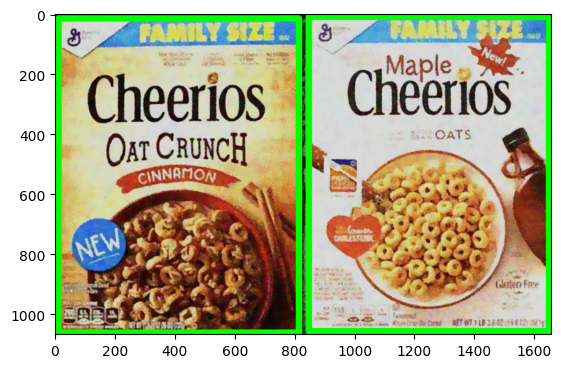

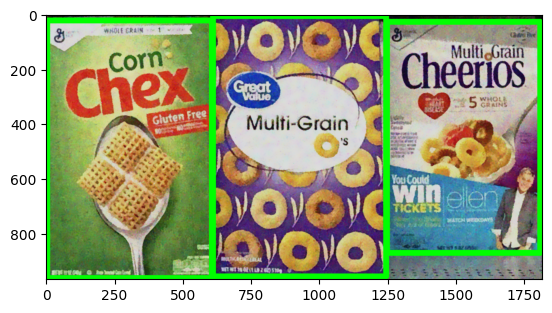

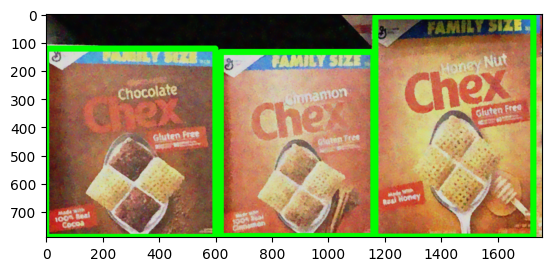

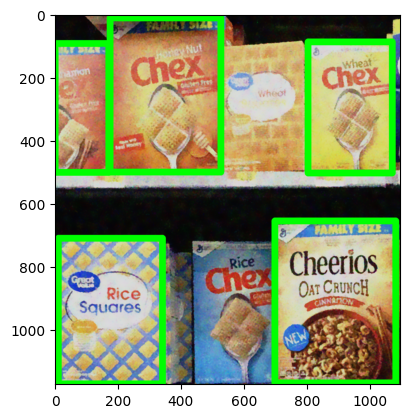

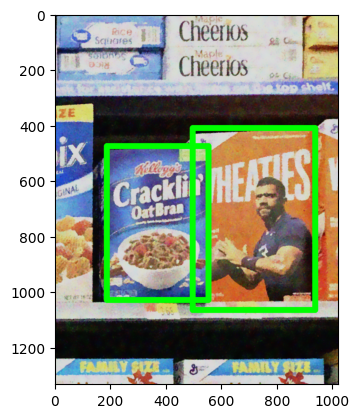

In [ ]:
single_instance_detector(filtered_scenes[:5], models[:14])

## Track B

Models: {ref15.png to ref27.png}.

Scenes: {scene6.png to scene12.png}.

### Multiple Instance Detector

The **Multiple instance detector** is an extension of the single instance approach, achieved by repeatedly applying the aforementioned process across each image.
After each detection the identified instance is masked out, regardless of whether it is a positive or negative match, allowing subsequent detections to focus on the remaining portions of the image.

In [ ]:
def multiple_instance_detector(scenes: list[np.ndarray], models: list[np.ndarray]) -> None:
  '''Detects multiple model objects in each scene image.

  Args:
      scenes: list[np.ndarray]
          Scene images where model objects are to be detected.

      models: list[np.ndarray]
          Objects to be detected.
  '''
  sift = cv2.SIFT_create()
  scenes_bb = copy.deepcopy(scenes)
  MIN_MATCH_COUNT = 20
  for model_idx, model in enumerate(models):
    kp_query, des_query = sift.detectAndCompute(model, None)
    for scene_idx, scene in enumerate(scenes):
      results = []
      scene_copy = scene.copy()
      while True:
        kp_train, des_train = sift.detectAndCompute(scene_copy, None)

        # Defining index for approximate kdtree algorithm
        FLANN_INDEX_KDTREE = 1

        # Defining parameters for algorithm
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

        # Checks attribute specifies the number of times the trees in the index should be recursively traversed.
        search_params = dict(checks = 250)

        # Initializing matcher
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Matching and finding the 2 closest elements for each query descriptor.
        matches = flann.knnMatch(des_query,des_train,k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)


        # Checking if we found enough matching

        if len(good)>MIN_MATCH_COUNT:

            # building the corrspondences arrays of good matches
            src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            kp_train_size = np.float32([ kp_train[m.trainIdx].size for m in good])

            # Using RANSAC to estimate a robust homography.
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            kp_train_size = kp_train_size[mask[:,0]==1]

            # Corners of the query image
            h,w,c = model.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = np.int32(cv2.perspectiveTransform(pts,M))
            x_dst_min = max(0,min(dst[:,0,0]))
            x_dst_max = min(max(dst[:,0,0]), scene_copy.shape[1]-1)
            y_dst_min = max(0,min(dst[:,0,1]))
            y_dst_max = min(max(dst[:,0,1]), scene_copy.shape[0]-1)
            w_d = x_dst_max-x_dst_min+1
            h_d = y_dst_max-y_dst_min+1
            if w_d > 25 and h_d > 25:
              if model.shape[0] >= h_d:
                scaled_model = cv2.resize(model,(w_d,h_d), cv2.INTER_AREA)
              else:
                scaled_model = cv2.resize(model,(w_d,h_d), cv2.INTER_LINEAR)
              scene_patch = scene_copy[y_dst_min:y_dst_max+1,x_dst_min:x_dst_max+1]

              #Converting RGB images into LAB space for later
              scaled_model = cv2.cvtColor(scaled_model,cv2.COLOR_RGB2LAB)
              scene_patch = cv2.cvtColor(scene_patch, cv2.COLOR_RGB2LAB)

              # Define r as the mean of the diameters of models' keypoints
              r = int(round(np.mean(kp_train_size)))

              #Compute data to build histograms
              scene_data  = compute_colour_means(scene_patch, r)
              model_data = compute_colour_means(scaled_model, r)

              n_bins_A = compute_bins(model_data[:,0])
              n_bins_B = compute_bins(model_data[:,1])
              model_hist = compute_hist(np.array(model_data), [n_bins_A, n_bins_B])
              scene_hist = compute_hist(np.array(scene_data), [n_bins_A, n_bins_B])

              #Compute Kullback-Lieber divergence to measure the distance between histograms
              kl_div = entropy(model_hist.flatten(), scene_hist.flatten())

              # Filter good matches with a threshold on Kullback-Lieber divergence
              if kl_div < 1.3:
                # Compute the center of the enclosing bounding box
                x_bb = round((x_dst_max+x_dst_min)/2)
                y_bb = round((y_dst_max+y_dst_min)/2)
                results.append([(x_bb, y_bb), w_d, h_d])
                cv2.rectangle(scenes_bb[scene_idx],(x_dst_min,y_dst_min),(x_dst_max,y_dst_max),(0,255,0),20, cv2.LINE_AA)

                # Mask good matches
                cv2.rectangle(scene_copy,(x_dst_min,y_dst_min),(x_dst_max,y_dst_max),0,-1)
              else:
                # Mask false positive matches
                cv2.rectangle(scene_copy,(x_dst_min,y_dst_min),(x_dst_max,y_dst_max),0,-1)
        else:
          break

      if len(results) > 0:
        printResults(scene_idx+5, model_idx+14, results)

  for scene in scenes_bb:
    plt.imshow(scene)
    plt.show()

Product 14 - Scene 5 - 2 instance found:
  Instance 1 {position: (583, 618), width: 325px, height: 906px}
  Instance 2 {position: (190, 618), width: 342px, height: 908px}
Product 15 - Scene 6 - 2 instance found:
  Instance 1 {position: (794, 461), width: 219px, height: 603px}
  Instance 2 {position: (1030, 460), width: 231px, height: 604px}
Product 16 - Scene 7 - 2 instance found:
  Instance 1 {position: (648, 567), width: 326px, height: 855px}
  Instance 2 {position: (989, 576), width: 331px, height: 856px}
Product 16 - Scene 10 - 2 instance found:
  Instance 1 {position: (166, 361), width: 185px, height: 483px}
  Instance 2 {position: (358, 366), width: 186px, height: 481px}
Product 18 - Scene 8 - 2 instance found:
  Instance 1 {position: (619, 374), width: 225px, height: 558px}
  Instance 2 {position: (848, 376), width: 226px, height: 568px}
Product 19 - Scene 8 - 2 instance found:
  Instance 1 {position: (1102, 357), width: 236px, height: 531px}
  Instance 2 {position: (1361, 376),

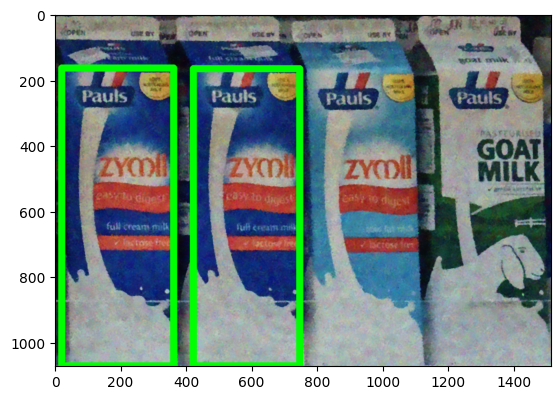

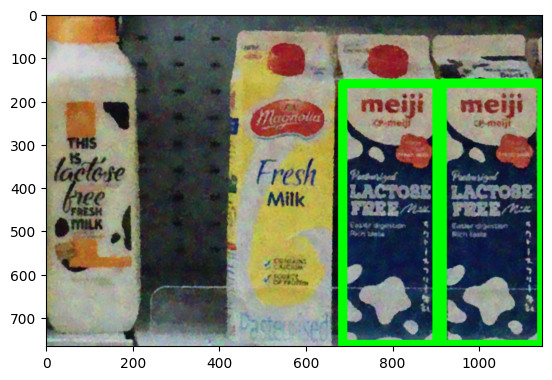

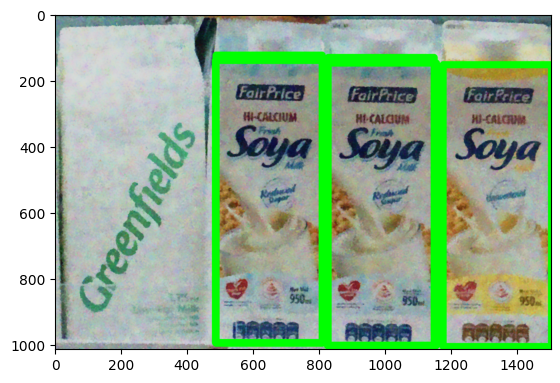

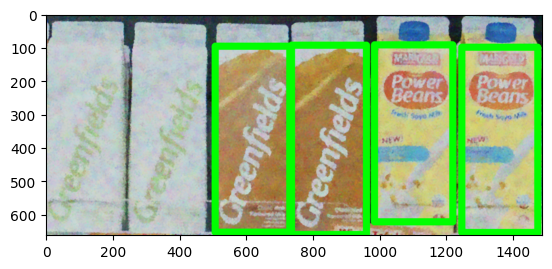

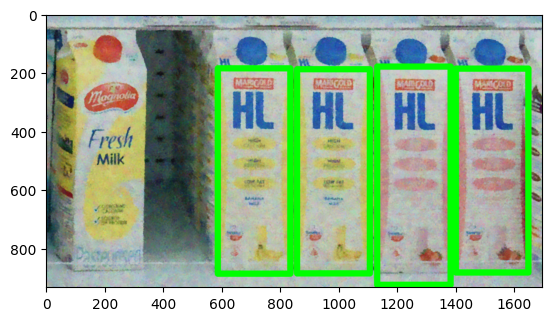

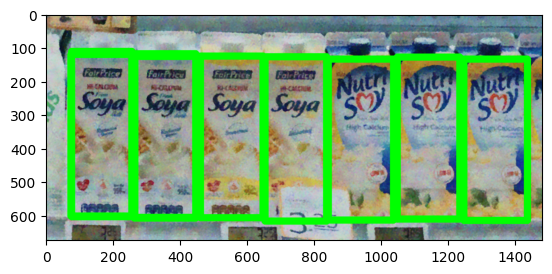

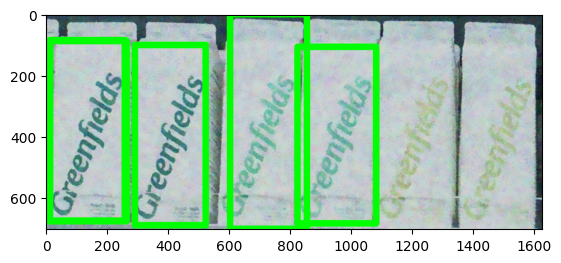

In [ ]:
multiple_instance_detector(filtered_scenes[5:],models[14:])

## Conclusion

Several methods have been evaluated for matching keypoints and regions in images but encountered issues related to noise robustness, patch size and overlapping regions:

    
**Discarding Keypoints Using L2 Distance in RGB Space**:
*    emoji-frown.svg Not robust to noise due to very small patch sizes around keypoints.

**Discarding Bounding Boxes with Pixel-wise Correlation (Template Matching)**:
*    emoji-frown.svg Not robust to noise and suffers from overlapping regions.

**Using Histograms on Bounding Boxes or on Keypoints**:


*    emoji-smile.svg Adresses overlapping.

*    emoji-frown.svg Difficult to tune the number of bins, and keypoint regions are not very informative in terms of color content.

**Calculating Delta Distance in LAB Color Space (Using Only A and B Channels)**:
*    emoji-smile.svg Averaging over patches reduces noise.
*   emoji-frown.svg Overlapping remains a problem, and the size of the patch is crucial for accurate results.

<h2>Current Solution:</h2>

*  emoji-smile.svg **Patch Size Determination**: We resolve the patch size issue by averaging over the diameter of the keypoints.
*  emoji-smile.svg **Noise Robustness**: Instead of extracting patches only from keypoints, we use the entire image to enhance robustness against noise.
* emoji-smile.svg  **Bin Tuning**: We apply the Freedman-Diaconis rule to automatically determine the optimal number of bins for histograms, eliminating the need for manual tuning.

## References

<a name="freedman-diaconis">1.</a> Freedman, D., & Diaconis, P. (1981). [On the histogram as a density estimator](https://doi.org/10.1007/BF01025868): L2 theory. Zeitschrift für Wahrscheinlichkeitstheorie und verwandte Gebiete, 57(4), 453–476.